In [ ]:
import pandas as pd
import numpy as np
import requests as rq
import time
from bs4 import BeautifulSoup as bs
from datetime import datetime, timedelta
from IPython.display import clear_output
import warnings

import re
import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore")

#  Сбор данных

### Парсим с Ленты

In [108]:
class lentaRu_parser:
    def __init__(self):
        pass

    def _get_url(self, param_dict: dict) -> str:
        """
        Возвращает URL для запроса json таблицы со статьями

        url = 'https://lenta.ru/search/v2/process?'\
        + 'from=0&'\                       # Смещение
        + 'size=1000&'\                    # Кол-во статей
        + 'sort=2&'\                       # Сортировка по дате (2), по релевантности (1)
        + 'title_only=0&'\                 # Точная фраза в заголовке
        + 'domain=1&'\                     # ??
        + 'modified%2Cformat=yyyy-MM-dd&'\ # Формат даты
        + 'type=1&'\                       # Материалы. Все материалы (0). Новость (1)
        + 'bloc=4&'\                       # Рубрика. Экономика (4). Все рубрики (0)
        + 'modified%2Cfrom=2020-01-01&'\
        + 'modified%2Cto=2020-11-01&'\
        + 'query='                         # Поисковой запрос
        """
        hasType = int(param_dict['type']) != 0
        hasBloc = int(param_dict['bloc']) != 0

        url = 'https://lenta.ru/search/v2/process?'\
        + 'from={}&'.format(param_dict['from'])\
        + 'size={}&'.format(param_dict['size'])\
        + 'sort={}&'.format(param_dict['sort'])\
        + 'title_only={}&'.format(param_dict['title_only'])\
        + 'domain={}&'.format(param_dict['domain'])\
        + 'modified%2Cformat=yyyy-MM-dd&'\
        + 'type={}&'.format(param_dict['type']) * hasType\
        + 'bloc={}&'.format(param_dict['bloc']) * hasBloc\
        + 'modified%2Cfrom={}&'.format(param_dict['dateFrom'])\
        + 'modified%2Cto={}&'.format(param_dict['dateTo'])\
        + 'query={}'.format(param_dict['query'])

        return url


    def _get_search_table(self, param_dict: dict) -> pd.DataFrame:
        """
        Возвращает pd.DataFrame со списком статей
        """
        url = self._get_url(param_dict)
        r = rq.get(url)
        search_table = pd.DataFrame(r.json()['matches'])

        return search_table


    def get_articles(self,
                     param_dict,
                     time_step = 37,
                     save_every = 5,
                     save_excel = True) -> pd.DataFrame:
        """
        Функция для скачивания статей интервалами через каждые time_step дней
        Делает сохранение таблицы через каждые save_every * time_step дней

        param_dict: dict
        ### Параметры запроса
        ###### project - раздел поиска, например, rbcnews
        ###### category - категория поиска, например, TopRbcRu_economics
        ###### dateFrom - с даты
        ###### dateTo - по дату
        ###### offset - смещение поисковой выдачи
        ###### limit - лимит статей, максимум 100
        ###### query - поисковой запрос (ключевое слово), например, РБК

        """
        param_copy = param_dict.copy()
        time_step = timedelta(days=time_step)
        dateFrom = datetime.strptime(param_copy['dateFrom'], '%Y-%m-%d')
        dateTo = datetime.strptime(param_copy['dateTo'], '%Y-%m-%d')
        if dateFrom > dateTo:
            raise ValueError('dateFrom should be less than dateTo')

        out = pd.DataFrame()
        save_counter = 0

        while dateFrom <= dateTo:
            param_copy['dateTo'] = (dateFrom + time_step).strftime('%Y-%m-%d')
            if dateFrom + time_step > dateTo:
                param_copy['dateTo'] = dateTo.strftime('%Y-%m-%d')
            print('Parsing articles from '\
                  + param_copy['dateFrom'] +  ' to ' + param_copy['dateTo'])
            # out = out.append(self._get_search_table(param_copy), ignore_index=True)
            out = pd.concat([out, self._get_search_table(param_copy)], axis=0)
            dateFrom += time_step + timedelta(days=1)
            param_copy['dateFrom'] = dateFrom.strftime('%Y-%m-%d')
            save_counter += 1
            if save_counter == save_every:
                clear_output(wait=True)
                out.to_csv("/tmp/checkpoint_table.csv", index=False)
                print('Checkpoint saved!')
                save_counter = 0
            time.sleep(5)

        if save_excel:
            out.to_csv("lenta_{}_{}.csv".format(
                param_dict['dateFrom'],
                param_dict['dateTo']), index=False)
        print('Finish')

        return out

In [132]:
# Задаем тут параметры
query = ''
offset = 0
size = 500
sort = "3"
title_only = "0"
domain = "1"
material = "0"
bloc = "0" # = topic = тематика новости
dateFrom = '2024-10-07'
dateTo = "2024-12-09"

param_dict = {'query'     : query,
              'from'      : str(offset),
              'size'      : str(size),
              'dateFrom'  : dateFrom,
              'dateTo'    : dateTo,
              'sort'      : sort,
              'title_only': title_only,
              'type'      : material,
              'bloc'      : bloc,
              'domain'    : domain}

print("param_dict:", param_dict)

param_dict: {'query': '', 'from': '0', 'size': '500', 'dateFrom': '2024-10-07', 'dateTo': '2024-12-09', 'sort': '3', 'title_only': '0', 'type': '0', 'bloc': '0', 'domain': '1'}


In [ ]:
parser = lentaRu_parser()

tbl = parser.get_articles(param_dict=param_dict,
                         time_step = 0,
                         save_every = 10,
                         save_excel = False)
print(len(tbl.index))

Checkpoint saved!
Parsing articles from 2024-12-06 to 2024-12-06
Parsing articles from 2024-12-07 to 2024-12-07
Parsing articles from 2024-12-08 to 2024-12-08
Parsing articles from 2024-12-09 to 2024-12-09
Finish
28074


In [ ]:
# подключение прерывалось, поэтому делал сохранения (part1, part2, ...)
# pd.concat([part1, part2, part3, part4, part5, tbl], axis=0).to_csv('lenta_daily_2024.csv', index=False)

In [4]:
data_2023 = pd.read_csv('lenta_daily_2023.csv')
data_2024 = pd.read_csv('lenta_daily_2024.csv')
tbl = pd.concat([data_2023, data_2024], axis=0)

In [11]:
tbl.shape

(295854, 17)

### Новости с РБК

In [6]:
class rbc_parser:
    def __init__(self):
        pass
    
    
    def _get_url(self, param_dict: dict) -> str:
        """
        Возвращает URL для запроса json таблицы со статьями
        """
        url = 'https://www.rbc.ru/search/ajax/?' +\
        'project={0}&'.format(param_dict['project']) +\
        'category={0}&'.format(param_dict['category']) +\
        'dateFrom={0}&'.format(param_dict['dateFrom']) +\
        'dateTo={0}&'.format(param_dict['dateTo']) +\
        'page={0}&'.format(param_dict['page']) +\
        'query={0}&'.format(param_dict['query']) +\
        'material={0}'.format(param_dict['material'])
        
        # 'offset={0}&'.format(param_dict['offset']) +\
        # 'limit={0}&'.format(param_dict['limit']) +\
        
        return url
    
    
    def _get_search_table(self, param_dict: dict,
                          include_text: bool = True) -> pd.DataFrame:
        """
        Возвращает pd.DataFrame со списком статей
        
        include_text: bool
        ### Если True, статьи возвращаются с текстами
        """
        url = self._get_url(param_dict)
        r = rq.get(url)
        search_table = pd.DataFrame(r.json()['items'])
        if include_text and not search_table.empty:
            get_text = lambda x: self._get_article_data(x['fronturl'])
            search_table[['overview', 'text']] = search_table.apply(get_text,
                                                                    axis=1).tolist()
        
        if 'publish_date_t' in search_table.columns:
            search_table.sort_values('publish_date_t', ignore_index=True)
            
        return search_table
    
    
    def _iterable_load_by_page(self, param_dict):
        param_copy = param_dict.copy()
        results = []
        
        result = self._get_search_table(param_copy)
        results.append(result)
        
        while not result.empty:
            param_copy['page'] = str(int(param_copy['page']) + 1)
            result = self._get_search_table(param_copy)
            results.append(result)
            
        results = pd.concat(results, axis=0, ignore_index=True)
        
        return results
    
    
    def _get_article_data(self, url: str):
        """
        Возвращает описание и текст статьи по ссылке
        """
        r = rq.get(url)
        soup = bs(r.text) # features="lxml" чтобы не было warning
        div_overview = soup.find('div', {'class': 'article__text__overview'})
        if div_overview:
            overview = div_overview.text.replace('<br />','\n').strip()
        else:
            overview = None
        p_text = soup.find_all('p')
        if p_text:
            text = ' '.join(map(lambda x:
                                x.text.replace('<br />','\n').strip(),
                                p_text))
        else:
            text = None
        
        return overview, text 
    
    def get_articles(self,
                     param_dict,
                     time_step = 1,
                     save_every = 5,
                     save_excel = True) -> pd.DataFrame:
        """
        Функция для скачивания статей интервалами через каждые time_step дней
        Делает сохранение таблицы через каждые save_every * time_step дней

        param_dict: dict
        ### Параметры запроса 
        ###### project - раздел поиска, например, rbcnews
        ###### category - категория поиска, например, TopRbcRu_economics
        ###### dateFrom - с даты
        ###### dateTo - по дату
        ###### query - поисковой запрос (ключевое слово), например, РБК
        ###### page - смещение поисковой выдачи (с шагом 20)
        
        ###### Deprecated:
        ###### offset - смещение поисковой выдачи
        ###### limit - лимит статей, максимум 100
        """
        param_copy = param_dict.copy()
        time_step = timedelta(days=time_step)
        dateFrom = datetime.strptime(param_copy['dateFrom'], '%d.%m.%Y')
        dateTo = datetime.strptime(param_copy['dateTo'], '%d.%m.%Y')
        if dateFrom > dateTo:
            raise ValueError('dateFrom should be less than dateTo')
        
        out = pd.DataFrame()
        save_counter = 0

        while dateFrom <= dateTo:
            param_copy['dateTo'] = (dateFrom + time_step).strftime("%d.%m.%Y")
            if dateFrom + time_step > dateTo:
                param_copy['dateTo'] = dateTo.strftime("%d.%m.%Y")
            print('Parsing articles from ' + param_copy['dateFrom'] +  ' to ' + param_copy['dateTo'])
            out = pd.concat([out, self._iterable_load_by_page(param_copy)], axis=0, ignore_index=True)
            dateFrom += time_step + timedelta(days=1)
            param_copy['dateFrom'] = dateFrom.strftime("%d.%m.%Y")
            save_counter += 1
            if save_counter == save_every:
                clear_output(wait=True)
                out.to_csv("/tmp/checkpoint_table.csv", index=False)
                print('Checkpoint saved!')
                save_counter = 0
            time.sleep(5)
        if save_excel:
            out.to_csv("rbc_{}_{}.csv".format(
                param_dict['dateFrom'],
                param_dict['dateTo']), index=False)
        print('Finish')
        
        return out

In [ ]:
query = 'РБК'
project = "rbcnews"
category = "TopRbcRu_economics"
material = ""
dateFrom = '2023-05-01'
dateTo = "2024-12-11"
page = 0

rbk_param_dict = {'query'   : query, 
                  'project' : project,
                  'category': category,
                  'dateFrom': datetime.
                  strptime(dateFrom, '%Y-%m-%d').
                  strftime('%d.%m.%Y'),
                  'dateTo'  : datetime.
                  strptime(dateTo, '%Y-%m-%d').
                  strftime('%d.%m.%Y'),
                  'page'   : str(page),
                  'material': material}

In [8]:
parser = rbc_parser()
table = parser.get_articles(param_dict=rbk_param_dict,
                             time_step = 9, # Шаг - 7 дней, можно больше,
                                            # но есть риск отсечения статей в неделях, гдестатей больше 100
                             save_every = 1, # Сохранять чекпойнт каждые 5 шагов
                             save_excel = False) # Сохранить итоговый файл
print(len(table))
table.head()

Checkpoint saved!
Parsing articles from 11.05.2023 to 20.05.2023


KeyboardInterrupt: 

In [ ]:
# pd.concat([part1, part2, part3, part4, part5, part6], axis=0).to_csv('rbk_part1.csv', index=False)

### Новости с РИА

`Среди тестовых топиков пока отсутствует "Строительство". Спарсим эти новости с "РИА".`

In [ ]:
SLEEP = 2
DEPTH = 2_000
BASE_URL = "https://ria.ru/"
TOPICS = ["tag_thematic_category_Stroitelstvo"]

In [24]:
@dataclass
class Article:
    id: str = None
    url: str = None
    title: str = None
    subtitle: str = None
    content: str = None
    datetime: str = None

In [90]:
# set webdriver params
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--blink-settings=imagesEnabled=false")
chrome_options.add_argument("headless")
chrome_options.add_argument("no-sandbox")
chrome_options.add_argument("disable-dev-shm-usage")
driver = webdriver.Chrome(options=chrome_options)

In [26]:
def get_pages():

    """Load and scroll pages"""

    items, topics_order = [], []

    for topic in tqdm(TOPICS):
        try:
            old_size = len(items)
            # URL = BASE_URL + topic
            URL = 'https://ria.ru/tag_thematic_category_Stroitelstvo/'
            driver.get(URL)
            time.sleep(SLEEP)

            # push to list 20 next articles
            driver.execute_script(
                "document.getElementsByClassName('list-more')[0].click()"
            )
            time.sleep(1)

            # scroll page to automatically load more articles
            for i in tqdm(range(DEPTH), leave=False):
                try:
                    driver.execute_script(
                        f"window.scrollTo(0, document.body.scrollHeight - 1200)"
                    )
                    time.sleep(1)
                except:
                    pass

            # find all pages
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")
            scope = soup.find(
                "div", {"class": "list", "itemtype": "http://schema.org/ItemList"}
            )
            items += scope.find_all("div", {"class": "list-item"})

            # number of pages can not be multiple of deepth*20
            # that's why we count topics_order dynamically
            new_size = len(items)
            if new_size > old_size:
                topics_order.extend([topic] * (new_size - old_size))
        except:
            pass

    return items, topics_order

In [57]:
def parse_page(page):
    """Extract from page desired fields"""

    # Create article data class object
    article = Article()

    # article url
    article.url = page.find("a", {"class": "list-item__image"})["href"]

    # article id
    s = re.findall(r"\d+.html", article.url)[0]
    article.id = s[: s.find(".")]

    # load page
    driver.get(article.url)
    time.sleep(SLEEP)
    html = driver.page_source
    # print(html)

    # article source
    source = article.url[8 : article.url.find(".")]

    # article object
    soup = BeautifulSoup(html, "html.parser")
    obj = soup.find(
        "div",
        {
            "class": lambda x: x and (x.find(f"article m-article m-{source}") > -1),
            "data-article-id": article.id,
        },
    )
    # print('obj1:')
    # print(obj)
    if not obj:
        obj = soup.find(
            "div",
            {
                "class": lambda x: x and (x.find(f"article m-video m-{source}") > -1),
                "data-article-id": article.id,
            },
        )
    # print('obj2:')
    # print(obj)
    # process article title
    # title = obj.find("div", {"class": "article__title"})
    # title_2 = obj.find("h1", {"class": "article__title"})

    # if title:
        # article.title = title.text
    # else:
        # article.title = title_2.text if title_2 else ""

    # article subtitle
    # subtitle = obj.find("h1", {"class": "article__second-title"})
    # article.subtitle = subtitle.text if subtitle else ""

    # article content
    article.content = obj.find(
        "div", {"class": "article__body js-mediator-article mia-analytics"}
    ).text
    return article.content

    # article datetime
    # article.datetime = obj.find("div", {"class": "article__info-date"}).find("a").text

    # article number of views
    # article.views = int(obj.find('span', {'class': 'statistic__item m-views'}).text)

    return article

In [28]:
# get pages and topics
pages, topics_order = get_pages()

100%|██████████| 1/1 [35:38<00:00, 2138.96s/it]


In [29]:
len(pages)

7160

In [32]:
with open("ria_pages.txt", "w", encoding="utf-8") as f:
    for page in pages:
        f.write("%s\n" % page)

In [107]:
from selenium.common.exceptions import WebDriverException

In [ ]:
data, topics_order_fixed = [], []

for num, page in enumerate(tqdm(pages)):
    try:
        data.append(parse_page(page))
        topics_order_fixed.append(topics_order[num])
        time.sleep(3)
    except AttributeError:
        print(f'{num} was skipped!')
        pass
    except WebDriverException:
        driver = webdriver.Chrome(options=chrome_options)
        data.append(parse_page(page))
        topics_order_fixed.append(topics_order[num])
        time.sleep(3)
            
# driver.close()

 94%|█████████▎| 6706/7160 [04:57<38:53,  5.14s/it] 

6705 was skipped!


 95%|█████████▌| 6806/7160 [19:55<43:44,  7.41s/it]  

6805 was skipped!


100%|██████████| 7160/7160 [1:10:36<00:00,  1.69it/s]


In [2]:
df = pd.DataFrame(data, columns=['text'])
df.to_csv('ria_stroyka1.csv',index=False)

In [28]:
# собираю все источники в единый датафрейм и сохраняю его
lenta1 = pd.read_csv('lenta_daily_2023.csv')
lenta2 = pd.read_csv('lenta_daily_2024.csv')
rbk = pd.read_csv('rbk_part1.csv')
ria = pd.read_csv('ria_stroyka1.csv')

In [29]:
# укажем верные номера тематик для новостей Ленты
lenta1 = lenta1[lenta1.bloc.isin([1, 37, 3, 4, 5, 8, 48, 87])]
lenta2 = lenta2[lenta2.bloc.isin([1, 37, 3, 4, 5, 8, 48, 87])]

# Найдем соответствие между кодом блока, его названием и кодом в соревновании:

# * 1 - Россия - 0
# * 37 - Силовые структуры - 2
# * 3 - Бывший СССР - 3
# * 4 - Экономика - 1
# * 5 - Наука и техника - 8
# * 8 - Спорт - 4
# * 48 - Туризм - 7
# * 87 - Здоровье - 5


TagsMap = {
    1 : 0, 
    3 : 3, 
    4 : 1, 
    5 : 8, 
    8 : 4, 
    37 : 2, 
    48 : 7, 
    87 : 5
}

lenta1['topic'] = lenta1['bloc'].map(TagsMap)
lenta2['topic'] = lenta2['bloc'].map(TagsMap)
lenta1 = lenta1[['text', 'topic']].reset_index(drop=True)
lenta2 = lenta2[['text', 'topic']].reset_index(drop=True)

In [30]:
# укажем верные номера тематик для новостей РБК
rbk = rbk[rbk.category.isin(['Общество', 'Экономика'])]
TagsMap2 = {
    'Общество' : 0, 
    'Экономика' : 1
}

rbk['topic'] = rbk['category'].map(TagsMap2)
rbk = rbk[['text', 'topic']].reset_index(drop=True)

In [31]:
# укажем верные номера тематик для новостей РИА
ria['topic'] = 6

In [39]:
full_df = pd.concat([lenta1, lenta2, rbk, ria], axis=0).reset_index(drop=True)
full_df.to_csv('DATA.csv', index=False)

In [ ]:
pd.read_csv('DATA.csv').shape

(203089, 2)

`По итогам сбора данных собрали датасет, который содержит более 200 тысяч статей по 9 тематикам.`

`Но прежде чем переходить к токенизации и обучению моделей предобработаем эти данные.`

# Предобработка данных

In [42]:
# удаляем полные дубликаты
full_df = full_df.drop_duplicates()

In [ ]:
# статистики длины текстов
full_df.text.str.len().describe()

count    198403.000000
mean       1327.188883
std        1266.014358
min           1.000000
25%         869.000000
50%        1067.000000
75%        1404.000000
max       52185.000000
Name: text, dtype: float64

`Видим, что есть текст длиной 1 символ :)))))`

In [ ]:
# оставлю 95% доверительный интервал для длин текстов
lower = full_df.text.str.len().quantile(0.025)
higher = full_df.text.str.len().quantile(0.975)
print(f'Нижняя граница (2.5 персентиль) = {lower}')
print(f'Верхняя граница (97.5 персентиль) = {higher}')
full_df = full_df[(full_df.text.str.len() >= lower) & (full_df.text.str.len() <= higher)]

Нижняя граница (2.5 персентиль) = 626.0
Верхняя граница (97.5 персентиль) = 3317.0


In [96]:
# в тематике Строительство в начале каждого текста встречается название сайти, город, дата, например:
full_df[full_df.topic == 6].head()['text']

195606    МОСКВА, 11 дек - РИА Недвижимость. Воронежский...
195607    БИШКЕК, 11 дек - РИА Новости. Строительство кр...
195608    МОСКВА, 10 дек - РИА Недвижимость. Продажи нов...
195609    МОСКВА, 10 дек - РИА Недвижимость. Прогнозируе...
195610    МОСКВА, 10 дек – РИА Недвижимость. Девелопер S...
Name: text, dtype: object

In [101]:
# уберем эти предложения из начала
full_df.loc[full_df.topic == 6, 'text'] = full_df[full_df.topic == 6].text.str.split('.').str[1:].str.join('.')

In [104]:
# как теперь выглядит, уже лучше :)
full_df[full_df.topic == 6].head()

,text,topic
195606,"Воронежский девелопер ""Развитие"" приобрел уча...",6
195607,Строительство крупнейшей в СНГ горнолыжной ба...,6
195608,Продажи новостроек массового сегмента Москвы ...,6
195609,Прогнозируемый объем ввода коммерческой недви...,6
195610,"Девелопер Sminex, выкупивший в октябре этого ...",6


In [105]:
# Посмотрим распределение по тематикам
TopicNames = {
    0: 'Россия',
    1: 'Экономика',
    2: 'Силовые структуры',
    3: 'Бывший СССР',
    4: 'Спорт',
    5: 'Здоровье',
    6: 'Строительство',
    7: 'Туризм',
    8: 'Наука и техника'
}

full_df['topic_name'] = full_df['topic'].apply(lambda x: TopicNames[x])

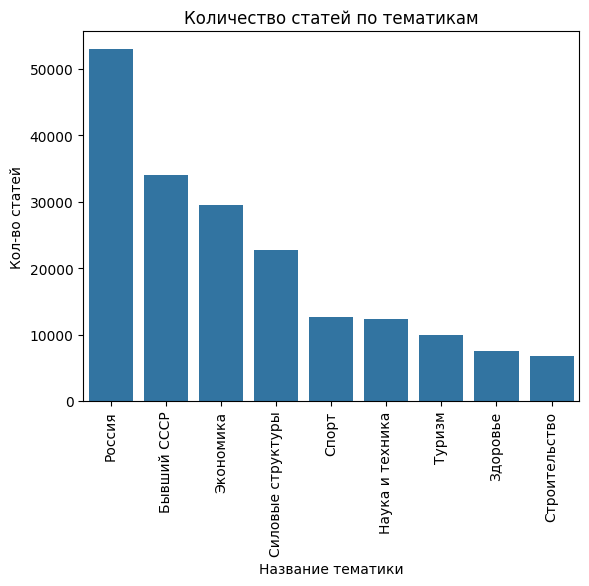

In [110]:
sns.barplot(full_df.topic_name.value_counts())
plt.xticks(rotation=90)
plt.title('Количество статей по тематикам')
plt.xlabel('Название тематики')
plt.ylabel('Кол-во статей')
plt.show()

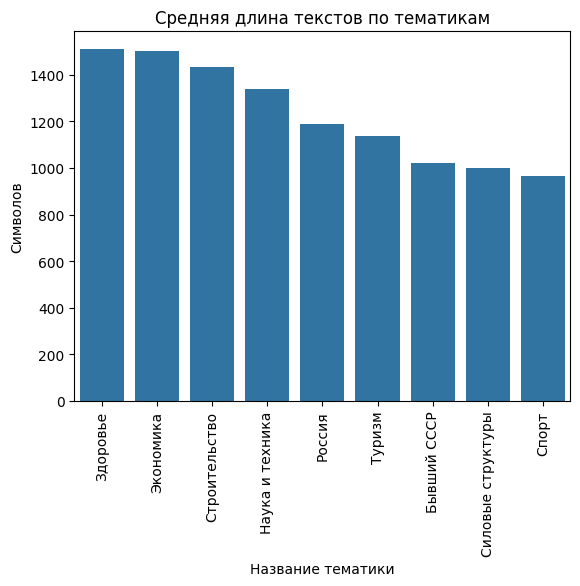

In [ ]:
# средняя длина текстов по тематикам 
full_df['text_len'] = full_df['text'].str.len()
sns.barplot(full_df.groupby('topic_name').text_len.mean().sort_values(ascending=False))
plt.xticks(rotation=90)
plt.title('Средняя длина текстов по тематикам')
plt.xlabel('Название тематики')
plt.ylabel('Символов')
plt.show()

`Видим, что в датасете преобладают статьи про Россию и бывший СССР. При этом наидлинейшие тексты у экономики и здоровья. Наиболее короткие - у новостей спорта.`

`Мы предобработали датасет, удалив дубликаты и аномальные тексты. По итогам данного этапа в датасете осталось 188 тыс текстов по 9 тематикам. Теперь можно переходить ко второй части.`

In [115]:
full_df.to_csv('CLEAR_DATA.csv', index=False)